## A runtime analysis

In [9]:
library(ggplot2)
library(ggpubr)

We read the observed times, which can be found [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Alex/Optimizing%20data%20reading.ipynb), in section 2 on 'Time complexity'.

In [10]:
x<- data.frame("1mil"=c(2.297, 2.513, 2.463), "9mil"=c(25.837, 23.488, 19.584),"25mil" = c(74.518, 79.681, 74.617))
colnames(x) <- c("V1", "V9", "V25")

In [11]:
x

V1,V9,V25
2.297,25.837,74.518
2.513,23.488,79.681
2.463,19.584,74.617


A summary and a Q-plot analysis are sufficient to already make note of the main concern: 

In [12]:
summary(x)

       V1              V9             V25       
 Min.   :2.297   Min.   :19.58   Min.   :74.52  
 1st Qu.:2.380   1st Qu.:21.54   1st Qu.:74.57  
 Median :2.463   Median :23.49   Median :74.62  
 Mean   :2.424   Mean   :22.97   Mean   :76.27  
 3rd Qu.:2.488   3rd Qu.:24.66   3rd Qu.:77.15  
 Max.   :2.513   Max.   :25.84   Max.   :79.68  

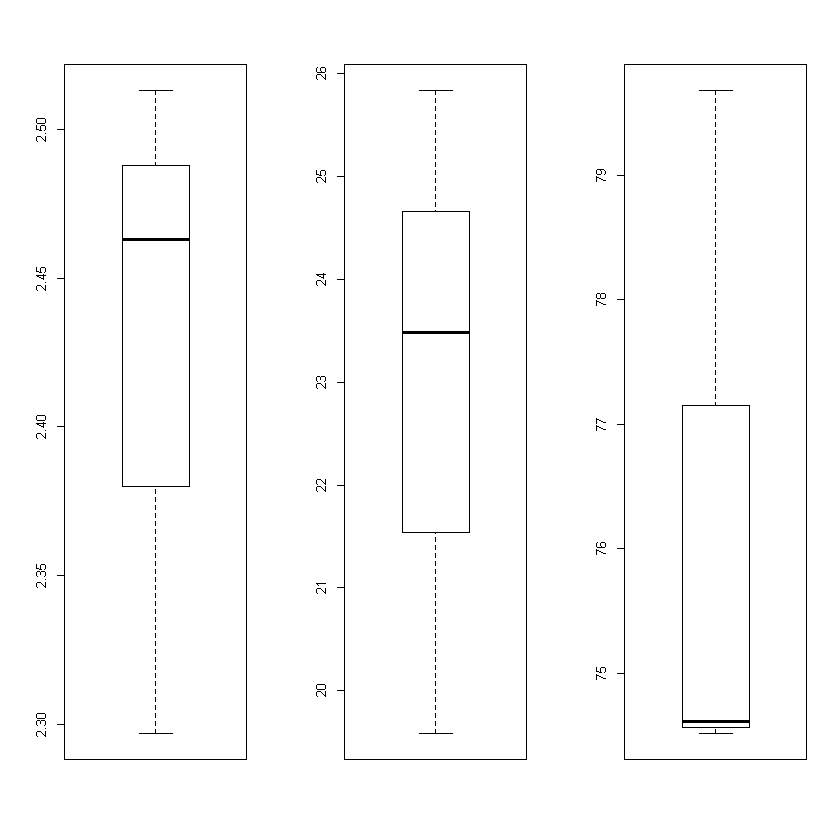

In [38]:
op <- par(mfrow=c(1,3))
boxplot(x$V1)
boxplot(x$V9)
boxplot(x$V25)
par(op)

Indeed, the proposed methods seem to hinder more than they help. In two of the three cases the times when using the na_filter are greater than the default time, and in one case it takes more time to read 7/11 selected features than it does to read the entire dataframe.

One explanation for this unusual result is that perhaps the 'usecols' command implicitly proposes some form of sequential approach in the reading. It might be the case that the program is iterating through the range and reading the 7 columns one-by-one, whereas its default version uses an implicit matrix reading technique. This is, however, just a hypothesis, and we chose not to test it any further.

In [16]:
y<- as.data.frame(t(x))
colnames(y) <- c("V1", "V9", "V25")
y<- cbind(y, lines=c(1,9,25))

In [17]:
y

,V1,V9,V25,lines
V1,2.297,2.513,2.463,1
V9,25.837,23.488,19.584,9
V25,74.518,79.681,74.617,25


The next step is to look at how increases behave in each of the 3 presented scenarios. We will do so by developing a mathematical algorithm for comparing increases, and then using some visualisations to back up the results. We start expecting a roughly linear increase.

In [20]:
summary(y[,-4])

       V1               V9              V25        
 Min.   : 2.297   Min.   : 2.513   Min.   : 2.463  
 1st Qu.:14.067   1st Qu.:13.001   1st Qu.:11.024  
 Median :25.837   Median :23.488   Median :19.584  
 Mean   :34.217   Mean   :35.227   Mean   :32.221  
 3rd Qu.:50.178   3rd Qu.:51.584   3rd Qu.:47.100  
 Max.   :74.518   Max.   :79.681   Max.   :74.617  

One thing to crucially note from the summary is that the mean value is always greater than the respective V9 value. We can use this fact to compute the N-increase tendency as follows: 

In [32]:
z<- y[,-4]
m<- vector()
weight_av<- vector()
n<- vector()

for(i in 1:ncol(z)) {
    m[i]<- mean(z[,i])
    weight_av[i]<- (sum(z[,i]/y[,4]))/ncol(z)
    n[i]<- z[2,i] + 4*weight_av[i] - m[i]
}

print(n)

[1]  2.4843304 -0.6593096 -2.4724267


The cases where n is positive represent the 'good' outcome, and the n negative ones the 'bad' outcome. Indeed, judging from the limited sample presented, we can notice a pattern of worsening as the datasize increases. Negative values of n entail that the difference between the mean value and what the mean value should have been is shifting favouring the former quantity. An increase in the average is positively correlated with larger jumps between values, as we can see:

In [39]:
cor(z)

,V1,V9,V25
V1,1.0000000,0.9982425,0.9953769
V9,0.9982425,1.0000000,0.9993193
V25,0.9953769,0.9993193,1.0000000


In [34]:
weight_av - min(z)

[1] 0.4191659 0.4730059 0.2442267

The weighted average compared to the V1 values of the 3 cases follows a weird stabilization pattern, inverse in effect to the implemented methods (eg. inverse to the performance of the NA_filter). This phenomena suggests that the stable development as N increases is closer to what we experience later in the process, i.e. at V25. Unfortunately, that's the least desirable scenario, where our alternative methods perform in fact worse than the default reading. 

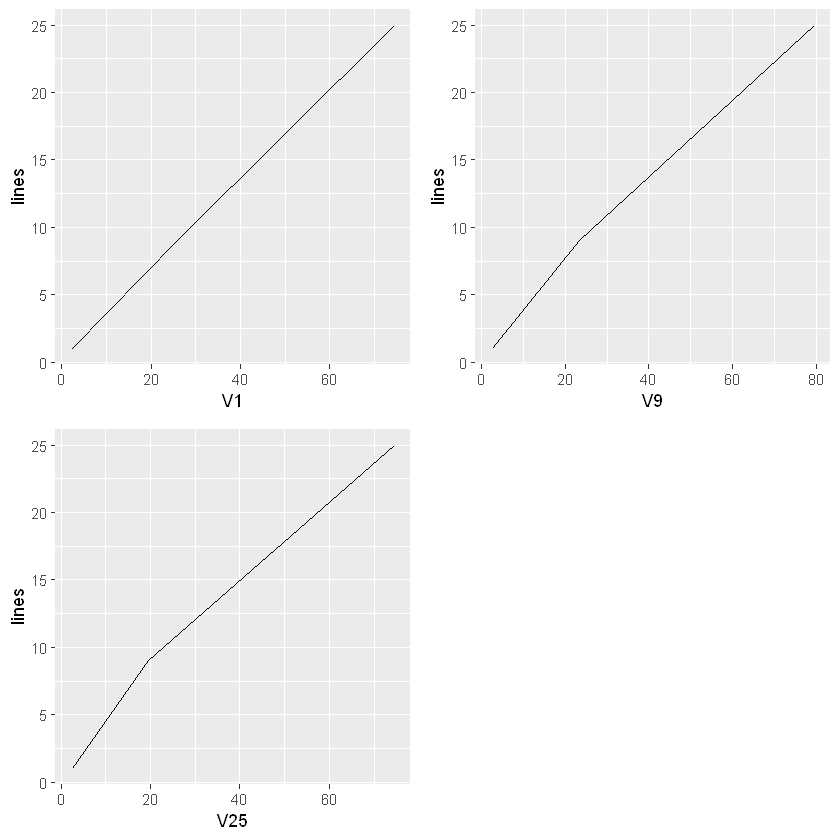

In [18]:
g1<- ggplot(y, aes(V1, lines)) + geom_line()
g2<- ggplot(y, aes(V9, lines)) + geom_line()
g3<- ggplot(y, aes(V25, lines)) + geom_line()

ggpubr::ggarrange(g1, g2, g3)

All increases are arbitrarily close to linear. However, we can observe that as N increases, the jump from small to medium sized data (V1 to V9) becomes harsher. This tendency disappears in the medium to large (V9 to V25) case. 

**Conclusions**

While the time complexity seems to mostly scale linearily with the data, there are two pressing issues in the way. The first is that the constant seems much higher in the short to medium datasize range, as seen in the transition from V1 to V9 in two of the cases, particularly in the last one. This also resulted in my personal device being unable to process the filtered version of V25 and crashing, whereas it could process the default version of V25 reading. We've drawn this conclusion both from visualisations, as well as from our weighted_average comparison across sectors. This is also somewhat seen in the Q-plots. The second, perhaps harsher, problem is that our attempts at filtering and selecting not only failed to reduce the time in two cases, it significantly increased. The analysis shows that the increase is in fact what we'd expect to happen as a trend - meaning that the methods are likely to fail as we attempt reading more data. This is highly problematic, since the alternatives were deployed precisely to combat greater masses of data, but perform notably worse as data increases, effectively undermining their initial purpose.